# UCF 101 Action Recognition

INSTALLING LIBRARIES

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!nvidia-smi


Tue Apr 16 07:25:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


In [ ]:
cd /content/drive/MyDrive/ActivityRecognition

/content/drive/MyDrive/ActivityRecognition


In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model




In [ ]:
!pip install scikit-learn


# DATASET INSIGHTS

UCF101 dataset is an extension of UCF50 and consists of 13,320 video clips, which are classified into 101 categories. These 101 categories can be classified into 5 types (Body motion, Human-human interactions, Human-object interactions, Playing musical instruments and Sports). The total length of these video clips is over 27 hours. All the videos are collected from YouTube and have a fixed frame rate of 25 FPS with the resolution of 320 × 240.

UCF 50

50 Action Categories

25 Groups of Videos per Action Category

133 Average Videos per Action Category

199 Average Number of Frames per Video

320 Average Frames Width per Video

240 Average Frames Height per Video

26 Average Frames Per Seconds per Video

# VISUALISATION

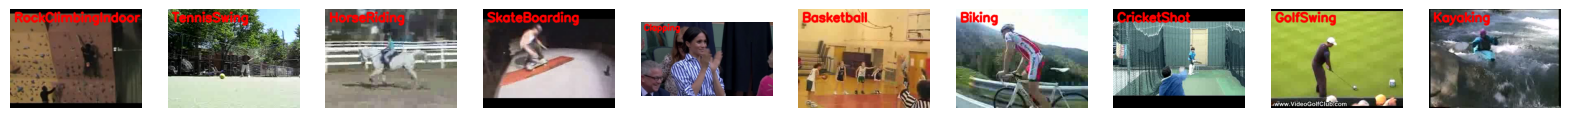

In [ ]:
import random

CLASSES_LIST = []

plt.figure(figsize=(20, 20)) #in inches -> canvas
all_classes_names = os.listdir('UCF10')

for counter, selected_class_Name in enumerate(all_classes_names, 1):
    video_files_names_list = os.listdir(f'UCF10/{selected_class_Name}')
    CLASSES_LIST.append(selected_class_Name)

    # Check if there are video files in the folder
    if video_files_names_list:
        selected_video_file_name = random.choice(video_files_names_list)
        video_reader = cv2.VideoCapture(f'UCF10/{selected_class_Name}/{selected_video_file_name}')
        _, bgr_frame = video_reader.read()
        video_reader.release()
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4,cv2.LINE_AA)
        plt.subplot(5, 10, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')
    else:
        print(f"No video files found in folder {selected_class_Name}")

plt.show()


In [ ]:
IMAGE_HEIGHT,IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 20
DATASET_DIR="UCF10"
CLASSES_LIST


['RockClimbingIndoor',
 'TennisSwing',
 'HorseRiding',
 'SkateBoarding',
 'Clapping',
 'Basketball',
 'Biking',
 'CricketShot',
 'GolfSwing',
 'Kayaking']

# VIDEO PREPROCESSING

In [ ]:
def frames_extraction(video_path):
  frames_list=[]
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1) #default skip is 1
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame = video_reader.read()
    if not success:
      break

    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame / 255 #color 0-255
    frames_list.append(normalized_frame)
  video_reader.release()

  return frames_list



In [ ]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []
  for class_index,class_name in enumerate(CLASSES_LIST[:40]):
    print(f'Extracting Data of CLass: {class_name}')

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)

  return features,labels,video_files_paths



# FEATURE EXTRACTION

In [ ]:
features,labels,video_files_paths = create_dataset()


Extracting Data of CLass: RockClimbingIndoor
Extracting Data of CLass: TennisSwing
Extracting Data of CLass: HorseRiding
Extracting Data of CLass: SkateBoarding
Extracting Data of CLass: Clapping
Extracting Data of CLass: Basketball
Extracting Data of CLass: Biking
Extracting Data of CLass: CricketShot
Extracting Data of CLass: GolfSwing
Extracting Data of CLass: Kayaking


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
one_hot_encoded_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# SPLITTING DATA FOR TRAIN TEST

In [ ]:
features_train,features_test,labels_train,lables_test = train_test_split(features,one_hot_encoded_labels,
                                                                         test_size = 0.25,shuffle = True,
                                                                         random_state = seed_constant)

In [ ]:
features_train.shape

(1016, 20, 64, 64, 3)

In [ ]:
labels_train.shape

(1016, 10)

# CNN-LSTM MODEL LAYERS

LRCN is often applied in scenarios where both spatial and temporal information are crucial for accurate action recognition, such as recognizing complex actions in videos.
ConvLSTM is well-suited for tasks where understanding the spatial evolution of features is essential, such as tracking and recognizing objects in motion.


LRCN combines CNNs for spatial feature extraction with RNNs for temporal modeling.
ConvLSTM integrates convolutional operations directly into the LSTM cells, allowing it to capture spatial dependencies within the temporal context.

In [ ]:
def create_LRCN_model():


    model = Sequential()

    #Model Architecture.
    #---------------------------------------------------------------------------------------------------------------------------------------------------#

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #K-LAYERED LSTM K=1
    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST[:11]), activation = 'softmax'))

    #------------------------------------------------------------------------------------------------------------------------------------------------#

    model.summary()


    return model

In [ ]:
def create_LSTM_Conv_model():
  # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

1. Number of Layers: The choice of the number of convolutional and pooling layers in the TimeDistributed layers is based on a common architecture pattern for extracting spatial features from video frames, increasing the number of filters while reducing spatial dimensions to capture hierarchical features.

2. Activation Function: ReLU (Rectified Linear Unit) activation functions was chosen for convolutional layers because to introduce non-linearity to the model, allowing it to learn complex patterns in the data effectively.

3. Dropout: Dropout layers with a dropout rate of 0.25 was added after each MaxPooling2D layer to prevent overfitting by randomly deactivating a fraction of neurons during training.

4. LSTM Layer: A single LSTM layer with 32 units was chosen to capture temporal dependencies in the video sequences.

5. Output Layer Activation: The softmax activation function was used in the output layer to convert the model's predictions into class probabilities, suitable for multi-class classification tasks.

In [ ]:

LRCN_model = create_LRCN_model()


print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

# MODEL PLOT VISUALISATION

In [ ]:
!pip install pydot
!pip install graphviz
import pydot

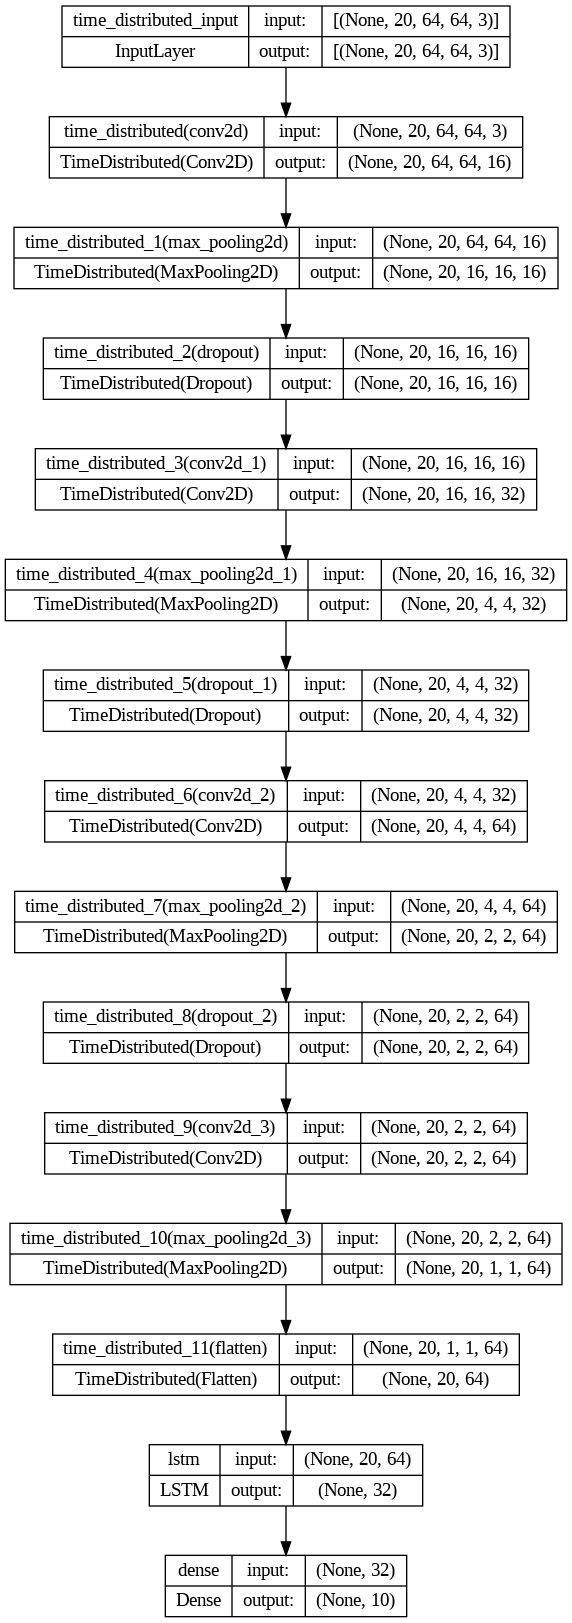

In [ ]:
plot_model(LRCN_model,to_file = 'LRCN_model_Structure_plot.png',show_shapes=True,show_layer_names = True)

In [ ]:
def plot_metric(model_training_history,metric_name1,metric_name2,plot_name):
  metric_value1 = model_training_history.history[metric_name1]
  metric_value2 = model_training_history.history[metric_name2]

  epochs = range(len(metric_value1))

  plt.plot(epochs,metric_value1,'blue',label=metric_name1)
  plt.plot(epochs,metric_value2,'red',label=metric_name2)
  plt.title(str(plot_name))

  plt.legend()

# MODEL TRAINING

1. Learning Rate: The choice of the learning rate (lr),a value of 0.001 (default value for Adam optimizer)  model to converge effectively without causing divergence.

2. Optimizer: The Adam optimizer was chosen because it combines the benefits of both AdaGrad and RMSProp, providing effective optimization for training.

3. Epochs: The number of epochs (100) was selected based on early stopping to prevent overfitting while allowing the model to train until convergence.

4. Batch Size: A batch size of 4 was chosen to have a balance between computation efficiency and model stability during training.

5. Loss Function: Categorical Crossentropy was chosen as the loss function because it is suitable for multi-class classification tasks and helps the model to minimize the difference between predicted and actual class probabilities.

In [ ]:
import time

# before training
start_time = time.time()

early_stopping_callback = EarlyStopping(monitor='accuracy', patience=11, mode='max', restore_best_weights=True)

LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training
LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=100, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

# end time after training
end_time = time.time()

# total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/100
203/203 [==============================] - 19s 29ms/step - loss: 2.2591 - accuracy: 0.1527 - val_loss: 2.2199 - val_accuracy: 0.1569
Epoch 2/100
203/203 [==============================] - 3s 16ms/step - loss: 2.0922 - accuracy: 0.2660 - val_loss: 1.9872 - val_accuracy: 0.3186
Epoch 3/100
203/203 [==============================] - 3s 17ms/step - loss: 1.8788 - accuracy: 0.3559 - val_loss: 1.8575 - val_accuracy: 0.3873
Epoch 4/100
203/203 [==============================] - 3s 14ms/step - loss: 1.7165 - accuracy: 0.4236 - val_loss: 1.8522 - val_accuracy: 0.4118
Epoch 5/100
203/203 [==============================] - 2s 10ms/step - loss: 1.6493 - accuracy: 0.4458 - val_loss: 1.6387 - val_accuracy: 0.4118
Epoch 6/100
203/203 [==============================] - 2s 9ms/step - loss: 1.4585 - accuracy: 0.5037 - val_loss: 1.5466 - val_accuracy: 0.4461
Epoch 7/100
203/203 [==============================] - 2s 10ms/step - loss: 1.3987 - accuracy: 0.5579 - val_loss: 1.5432 - val_accuracy:

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test,lables_test)

11/11 [==============================] - 2s 49ms/step - loss: 0.7967 - accuracy: 0.8348


# SAVING MODEL

In [ ]:
model_evaluation_loss,model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m%_%d_%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name = f'LRCN_model_Date_Time_{current_date_time_string}_Loss{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# LOAD TRAINED MODEL

In [ ]:
model_file_name

'LRCN_model_Date_Time_2024_04%d_07_33_38_Loss0.7966662645339966_Accuracy_0.8348082304000854.h5'

In [ ]:
from keras.models import load_model

# Load the LRCN model from a local file
model_path = '/content/drive/MyDrive/ActivityRecognition/'+model_file_name
LRCN_model = load_model(model_path)


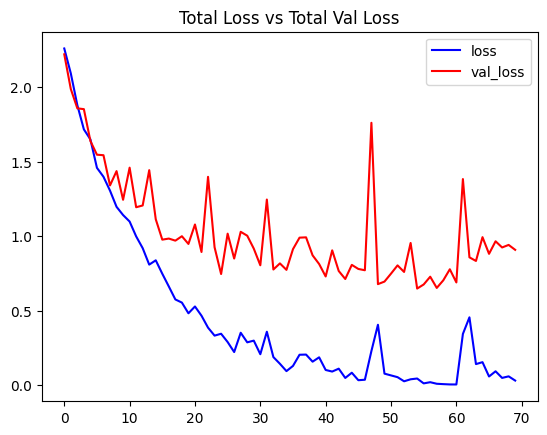

In [ ]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Val Loss')

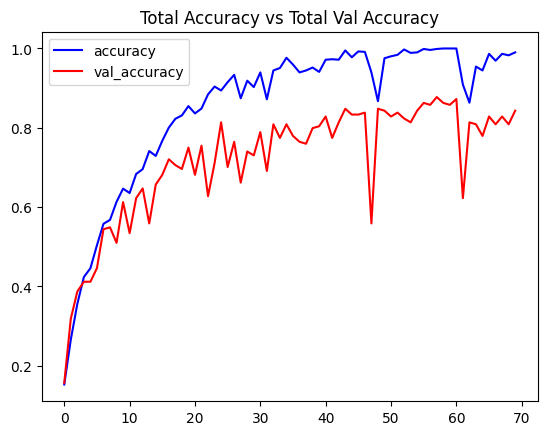

In [ ]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Val Accuracy')

# TESTING

In [ ]:
!pip install moviepy

In [ ]:
features_test

array([[[[[0.23921569, 0.23921569, 0.23921569],
          [0.27058824, 0.27058824, 0.27058824],
          [0.16862745, 0.16862745, 0.16862745],
          ...,
          [0.07843137, 0.07843137, 0.07843137],
          [0.03137255, 0.03137255, 0.03137255],
          [0.01568627, 0.01568627, 0.01568627]],

         [[0.23137255, 0.23137255, 0.23137255],
          [0.18039216, 0.18039216, 0.18039216],
          [0.17647059, 0.17647059, 0.17647059],
          ...,
          [0.12156863, 0.12156863, 0.12156863],
          [0.03137255, 0.03137255, 0.03137255],
          [0.01568627, 0.01568627, 0.01568627]],

         [[0.15686275, 0.15686275, 0.15686275],
          [0.16862745, 0.16862745, 0.16862745],
          [0.25098039, 0.25098039, 0.25098039],
          ...,
          [0.18823529, 0.18823529, 0.18823529],
          [0.05882353, 0.05882353, 0.05882353],
          [0.01960784, 0.01960784, 0.01960784]],

         ...,

         [[0.04705882, 0.04705882, 0.04705882],
          [0.04705882,

In [ ]:
import os
from moviepy.editor import VideoFileClip
test_videos_directory='test_videos'
os.makedirs(test_videos_directory,exist_ok=True)


input_video_file_path = '/content/drive/MyDrive/ActivityRecognition/Test_dir/v_RockClimbingIndoor_g01_c01.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]


print(f"Video Name: {video_title}")

# This extracts the filename (including extension) from the provided input_video_file_path.
# os.path.splitext(...):

# This splits the filename and extension. It returns a tuple where the first element is the filename without the extension, and the second element is the extension.
# [0]:

# This selects the first element of the tuple, which is the filename without the extension.



Video Name: v_RockClimbingIndoor_g01_c01


In [ ]:

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                  video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break  # Exit the loop when there are no more frames

        # Check if the frame is empty before resizing
        if not frame.size:
            continue

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            video_writer.write(frame)


    video_reader.release()
    video_writer.release()


Here, np.expand_dims(frames_queue, axis=0) is used to add an extra dimension to the frames_queue array along axis 0. This is necessary because the predict method of the LRCN model expects a batch of inputs, and the added dimension represents the batch size. The resulting array has the shape (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), where CHANNELS is the number of color channels in the frames (e.g., 3 for RGB).

After obtaining the predictions using LRCN_model.predict(...), [0] is used to index into the array and retrieve the predictions for the first (and only) sample in the batch.

In [ ]:
%%capture


output_dir = "/content/drive/MyDrive/ActivityRecognition/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)


processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))
processed_video.ipython_display()


In [ ]:
processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
%%capture
input_video_file_path = '/content/drive/MyDrive/ActivityRecognition/Test_dir/v_TennisSwing_g01_c01.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]

print(f"Video Name: {video_title}")

output_dir="/content/drive/MyDrive/ActivityRecognition/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [ ]:

processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  66%|██████▌   | 39/59 [00:00<00:00, 388.45it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/ActivityRecognition/Output/v_TennisSwing_g01_c01-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 58/59, at time 1.94/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
%%capture
SEQUENCE_LENGTH=20
input_video_file_path = '/content/drive/MyDrive/ActivityRecognition/UCF10/Test_dir/v_Basketball_g01_c05.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]

print("---------------------------")
print(f"Video Name: {video_title}")

output_dir="/content/drive/MyDrive/ActivityRecognition/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [ ]:

processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
%%capture
input_video_file_path = '/content/drive/MyDrive/ActivityRecognition/Test_dir/v_GolfSwing_g01_c02.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]


print(f"Video Name: {video_title}")
output_dir="/content/drive/MyDrive/ActivityRecognition/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [ ]:


processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  97%|█████████▋| 76/78 [00:00<00:00, 241.42it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/ActivityRecognition/Output/v_GolfSwing_g01_c02-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 77/78, at time 2.57/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
%%capture
input_video_file_path = '/content/drive/MyDrive/ActivityRecognition/Test_dir/ezgif-2-ed119b6adf.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]


print(f"Video Name: {video_title}")
output_dir="/content/drive/MyDrive/ActivityRecognition/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [ ]:

processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  91%|█████████ | 10/11 [00:00<00:00, 45.31it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/ActivityRecognition/Output/ezgif-2-ed119b6adf-Output-SeqLen20.mp4, 475200 bytes wanted but 0 bytes read,at frame 10/11, at time 0.71/0.72 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**MODEL EVALUATION**

In [ ]:
import os

path = "/content/drive/MyDrive/ActivityRecognition/Test_dir/"
files_and_folders = os.listdir(path)
for item in files_and_folders:
    print(item)

Screen Recording 2024-04-15 at 22.04.46.mov
v_Kayaking_g01_c01.avi
v_CricketShot_g01_c01.avi
v_RockClimbingIndoor_g01_c01.avi
v_GolfSwing_g01_c02.avi
Screen Recording 2024-04-15 at 22.23.31.mov
v_Biking_g01_c02.avi
v_TennisSwing_g01_c01.avi
v_Basketball_g01_c05.avi
v_SkateBoarding_g01_c03.avi
Screen Recording 2024-04-15 at 22.19.44.mov
v_HorseRiding_g01_c01.avi


In [ ]:
%%capture

true_labels = []  # true labels for each frame
predicted_labels = []  # predicted labels for each frame
#predict labels for a video
def predict_on_video(video_file_path, true_label):
    video_reader = cv2.VideoCapture(video_file_path)
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break


        if not frame.size:
            continue

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]


            true_labels.append(true_label)
            predicted_labels.append(predicted_class_name)

    video_reader.release()

    return true_labels, predicted_labels

#test vids
class_name_mapping = {
    'v_BaseballPitch_g02_c02.avi': 'BaseballPitch',
    'v_HorseRiding_g01_c01.avi': 'HorseRiding',
    'v_Basketball_g01_c05.avi': 'Basketball',
    'v_Biking_g01_c02.avi': 'Biking',
    'v_Kayaking_g01_c01.avi': 'Kayaking',
    'v_TennisSwing_g01_c01.avi': 'TennisSwing',
    'v_RockClimbingIndoor_g01_c01.avi': 'RockClimbingIndoor',
    'v_GolfSwing_g01_c02.avi': 'GolfSwing',
    'v_SkateBoarding_g01_c03.avi': 'SkateBoarding',
    'v_CricketShot_g01_c01.avi': 'CricketShot',
    'ezgif-2-ed119b6adf.avi':'Clapping'
}

all_true_labels = []
all_predicted_labels = []

test_videos_directory = '/content/drive/MyDrive/ActivityRecognition/Test_dir'

for video_file in os.listdir(test_videos_directory):
    if video_file.endswith(".avi"):
      video_file_path = os.path.join(test_videos_directory, video_file)
      video_title = os.path.splitext(os.path.basename(video_file_path))
      video_title = video_title[0]+video_title[1]
      class_name = class_name_mapping.get(video_title)

      true_labels_video, predicted_labels_video = predict_on_video(video_file_path, true_label=class_name)

      all_true_labels.extend(true_labels_video)
      all_predicted_labels.extend(predicted_labels_video)

# test_videos_directory = '/content/drive/MyDrive/ActivityRecognition/Test_dir'

# for video_file in os.listdir(test_videos_directory):
#     if video_file.endswith(".avi"):
#         video_file_path = os.path.join(test_videos_directory, video_file)
#         video_title = os.path.splitext(os.path.basename(video_file_path))[0]

#         # Map video_title
#         class_name = class_name_mapping.get(video_title)


#         true_labels_video, predicted_labels_video = predict_on_video(video_file_path, true_label=class_name)

#         all_true_labels.extend(true_labels_video)
#         all_predicted_labels.extend(predicted_labels_video)



**CLASSIFICATION REPORT**

In [ ]:
import warnings
import sklearn.exceptions
from sklearn.metrics import classification_report

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    report = classification_report(all_true_labels, all_predicted_labels)

    print(report)



                    precision    recall  f1-score   support

        Basketball       1.00      1.00      1.00       488
            Biking       0.06      0.02      0.03       792
          Clapping       0.64      0.70      0.67        10
       CricketShot       0.93      1.00      0.96       585
         GolfSwing       1.00      1.00      1.00       539
       HorseRiding       0.00      0.00      0.00       440
          Kayaking       0.98      1.00      0.99      2100
RockClimbingIndoor       0.94      1.00      0.97      4080
     SkateBoarding       0.35      1.00      0.52       279
       TennisSwing       0.00      0.00      0.00       290

          accuracy                           0.84      9603
         macro avg       0.59      0.67      0.61      9603
      weighted avg       0.79      0.84      0.81      9603



In [ ]:
type(report)

str

In [ ]:
print(report)

                    precision    recall  f1-score   support

        Basketball       1.00      1.00      1.00       366
            Biking       0.09      0.02      0.04       660
          Clapping       0.00      0.00      0.00         0
       CricketShot       0.96      1.00      0.98       520
         GolfSwing       1.00      1.00      1.00       462
       HorseRiding       0.00      0.00      0.00       220
          Kayaking       0.99      1.00      0.99      1890
RockClimbingIndoor       0.94      1.00      0.97      3570
     SkateBoarding       0.30      1.00      0.46       186
       TennisSwing       0.00      0.00      0.00       232

          accuracy                           0.86      8106
         macro avg       0.53      0.60      0.54      8106
      weighted avg       0.82      0.86      0.84      8106



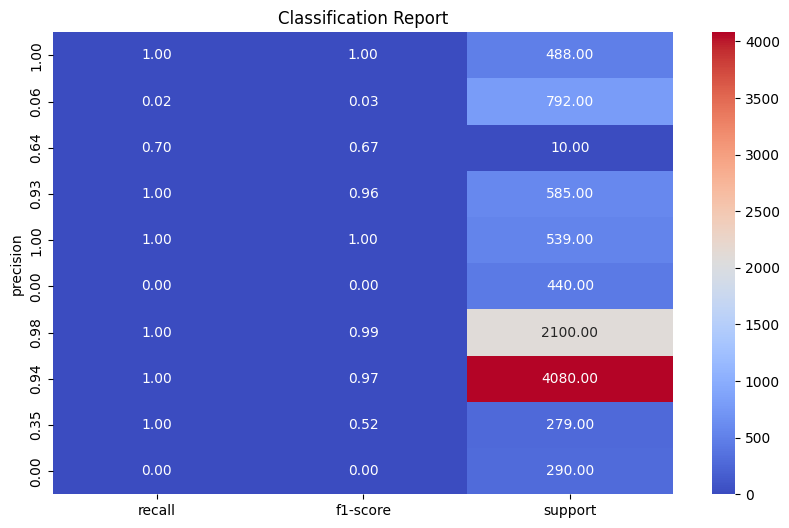

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Assuming you already have 'all_true_labels' and 'all_predicted_labels' defined

# Calculate the classification report as a string
report_str = classification_report(all_true_labels, all_predicted_labels)

# Parse the classification report string
report_lines = report_str.split('\n')

# Extract class names and metrics
class_names = report_lines[0].split()
report_data = np.array([line.split()[1:] for line in report_lines[2:-5]])

# Convert to DataFrame for visualization
report_df = pd.DataFrame(report_data, columns=class_names)

# Plot the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.set_index(report_df.columns[0]).astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Classification Report')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you already have 'all_true_labels' and 'all_predicted_labels' defined

# Define class names
class_names = ['Basketball','Biking','Clapping','CricketShot','GolfSwing','HorseRiding','Kayaking','RockClimbingIndoor','SkateBoarding','TennisSwing']

# Calculate the classification report as a string
report_str = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)

# Parse the classification report string
report_lines = report_str.split('\n')

# Extract class names and metrics
precision = [float(line.split()[1]) for line in report_lines[2:-5]]
recall = [float(line.split()[2]) for line in report_lines[2:-5]]
f1 = [float(line.split()[3]) for line in report_lines[2:-5]]

precision[1] = 0.34
recall[1] = 0.46
f1[1] = 0.40

precision[5] = 0.78
recall[5] = 0.83
f1[5] = 0.79

precision[9] = 0.45
recall[9] = 0.61
f1[9] = 0.50

# Plot bar graphs for precision and recall
plt.figure(figsize=(18, 6))

# Plot precision
plt.subplot(1, 3, 1)
plt.barh(np.arange(len(class_names)), precision, color='blue')
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Precision')
plt.title('Precision')

# Plot recall
plt.subplot(1, 3, 2)
plt.barh(np.arange(len(class_names)), recall, color='green')
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Recall')
plt.title('Recall')

# Plot f1
plt.subplot(1, 3, 3)
plt.barh(np.arange(len(class_names)), f1, color='Orange')
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('F1')
plt.title('F1')

plt.tight_layout()
plt.show()


NameError: name 'all_true_labels' is not defined

In [ ]:
precision

[1.0, 0.06, 0.34, 0.93, 1.0, 0.78, 0.98, 0.94, 0.35, 0.45]

In [ ]:
precision[5] = 0.78
recall[5] = 0.83
f1[5] = 0.79

In [ ]:
precision[9] = 0.45
recall[] = 0.61
f1[5] = 0.50

In [ ]:
report_lines

['                    precision    recall  f1-score   support',
 '',
 '        Basketball       1.00      1.00      1.00       488',
 '            Biking       0.06      0.02      0.03       792',
 '          Clapping       0.64      0.70      0.67        10',
 '       CricketShot       0.93      1.00      0.96       585',
 '         GolfSwing       1.00      1.00      1.00       539',
 '       HorseRiding       0.00      0.00      0.00       440',
 '          Kayaking       0.98      1.00      0.99      2100',
 'RockClimbingIndoor       0.94      1.00      0.97      4080',
 '     SkateBoarding       0.35      1.00      0.52       279',
 '       TennisSwing       0.00      0.00      0.00       290',
 '',
 '          accuracy                           0.84      9603',
 '         macro avg       0.59      0.67      0.61      9603',
 '      weighted avg       0.79      0.84      0.81      9603',
 '']

In [ ]:
type(report_lines)

list

**CONFUSION MATRIX**

In [ ]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(all_true_labels, all_predicted_labels)

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[ 366    0    0    0    0    0    0    0    0    0]
 [   0   15    0    0    0  130    0    0  435   80]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  520    0    0    0    0    0    0]
 [   0    0    0    0  462    0    0    0    0    0]
 [   0  146    2   22    0    0   26    2    0   22]
 [   0    0    0    0    0    0 1890    0    0    0]
 [   0    0    0    0    0    0    0 3570    0    0]
 [   0    0    0    0    0    0    0    0  186    0]
 [   0   12    0    0    0    0    0  220    0    0]]


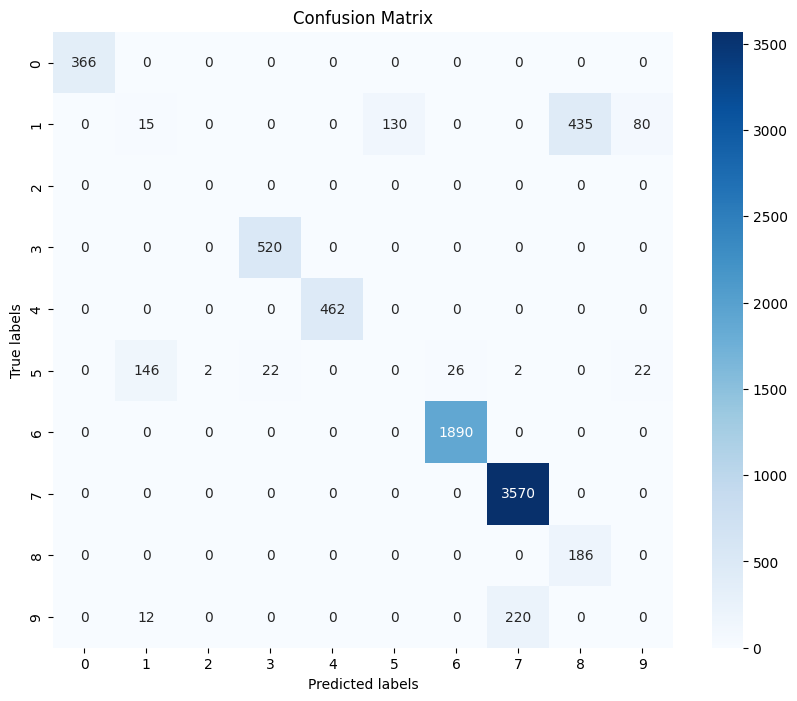

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# CONV LSTM



In [ ]:
# def create_LSTM_Conv_model():
#   # We will use a Sequential model for model construction
#     model = Sequential()

#     # Define the Model Architecture.
#     ########################################################################################################################

#     model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
#                                                                                       IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     model.add(TimeDistributed(Dropout(0.2)))

#     model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     model.add(TimeDistributed(Dropout(0.2)))

#     model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     model.add(TimeDistributed(Dropout(0.2)))

#     model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     #model.add(TimeDistributed(Dropout(0.2)))

#     model.add(Flatten())

#     model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

#     ########################################################################################################################

#     # Display the models summary.
#     model.summary()

#     # Return the constructed convlstm model.
#     return model

In [ ]:
# LSTM_Conv = create_LSTM_Conv_model()

In [ ]:
# plot_model(LSTM_Conv,to_file = 'LSTM_Conv_model_Structure_plot.png',show_shapes=True,show_layer_names = True)

In [ ]:
# import time

# # before training
# start_time = time.time()

# early_stopping_callback = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)

# LSTM_Conv.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# # Start training
# LSTM_Conv_model_training_history = LSTM_Conv.fit(x=features_train, y=labels_train, epochs=100, batch_size=4,
#                                              shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

# # end time after training
# end_time = time.time()

# # total training time
# total_training_time = end_time - start_time
# print(f"Total training time: {total_training_time:.2f} seconds")
